In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:

def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    x = x - np.max(x, axis=axis, keepdims=True)
    ex = np.exp(x, dtype=np.float32)
    return ex / np.sum(ex, axis=axis, keepdims=True, dtype=np.float32)

def gelu(x: np.ndarray) -> np.ndarray:
    return np.float32(0.5) * x * (np.float32(1.0) + np.tanh(np.sqrt(np.float32(2.0 / np.pi)) * (x + np.float32(0.044715) * (x ** 3))))


class LayerNorm:
    def __init__(self, d_model: int, eps: float = 1e-5):
        if d_model <= 0:
            raise ValueError("Warning: d_model must be > 0, got {d_model} instead")
        self.gamma = np.ones((d_model,), dtype=np.float32)
        self.beta  = np.zeros((d_model,), dtype=np.float32)
        self.eps = float(eps)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        if x.shape[-1] != self.gamma.shape[0]:
            raise ValueError(
                f"Warning: expected last dim {self.gamma.shape[0]}, got {x.shape[-1]} "
                f"for input shape {x.shape}")
        m = np.mean(x, axis=-1, keepdims=True)
        v = np.var(x, axis=-1, keepdims=True)
        xhat = (x - m) / np.sqrt(v + self.eps, dtype=np.float32)
        return self.gamma * xhat + self.beta

class Linear:
    def __init__(self, in_features: int, out_features: int, rng: np.random.Generator, std: float = 0.02):
        if in_features <= 0 or out_features <= 0:
            raise ValueError("Warning: invalid shape ({in_features}, {out_features})")
        W = rng.standard_normal((in_features, out_features)) * std
        self.W = W.astype(np.float32)
        self.b = np.zeros((out_features,), dtype=np.float32)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        if x.shape[-1] != self.W.shape[0]:
            raise ValueError(
                f"Warning: expected last dim {self.W.shape[0]}, got {x.shape[-1]} "
                f"for input shape {x.shape}"
            )
        return x @ self.W + self.b

class TokenEmbedding:
    def __init__(self, vocab_size: int, d_model: int, rng: np.random.Generator, std: float = 0.02):
        if vocab_size <= 0 or d_model <= 0:
            raise ValueError(f"Warning: invalid shape ({vocab_size}, {d_model})")
        w = rng.standard_normal((vocab_size, d_model)) * std
        self.weight = w.astype(np.float32)

    def __call__(self, token_ids: np.ndarray) -> np.ndarray:
        if token_ids.dtype.kind not in ("i", "u"):
            raise TypeError("Warning: token_ids must be an integer array")
        if np.any((token_ids < 0) | (token_ids >= self.weight.shape[0])):
            raise ValueError("Warning: token_id out of range")
        return self.weight[token_ids]

def get_sinusoidal_positional_encoding(max_seq_len: int, d_model: int) -> np.ndarray:
    if d_model % 2 != 0:
        raise ValueError("Sinusoidal PE: d_model must be even")
    position = np.arange(max_seq_len, dtype=np.float32)[:, None]
    div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * (-np.log(10000.0) / d_model))
    pe = np.zeros((max_seq_len, d_model), dtype=np.float32)
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

class _RopeCache:
    def __init__(self):
        self._cache = {}

    def get(self, S: int, Dh: int, base: float) -> Tuple[np.ndarray, np.ndarray]:
        key = (S, Dh, float(base))
        if key in self._cache:
            return self._cache[key]
        if Dh % 2 != 0:
            raise ValueError("Warning: head_dim must be even, got {Dh} instead")
        half = Dh // 2
        idx = np.arange(half, dtype=np.float32)
        theta = base ** (-2.0 * idx / Dh)
        pos = np.arange(S, dtype=np.float32)
        angles = pos[:, None] * theta[None, :]
        cos = np.cos(angles, dtype=np.float32)[None, None, :, :]
        sin = np.sin(angles, dtype=np.float32)[None, None, :, :]
        self._cache[key] = (cos, sin)
        return cos, sin
_rope_cache = _RopeCache()

def apply_rope(q: np.ndarray, k: np.ndarray, base: float = 10000.0) -> Tuple[np.ndarray, np.ndarray]:
    if q.shape != k.shape:
        raise ValueError("Warning: q and k must share shape, got {q.shape} vs {k.shape} instead")
    B, H, S, Dh = q.shape
    cos, sin = _rope_cache.get(S, Dh, base)
    half = Dh // 2

    def _rotate(x: np.ndarray) -> np.ndarray:
        x1, x2 = x[..., :half], x[..., half:]
        xr1 = x1 * cos - x2 * sin
        xr2 = x1 * sin + x2 * cos
        return np.concatenate([xr1, xr2], axis=-1)
    return _rotate(q), _rotate(k)

class ScaledDotProductAttention:
    def __call__(self, q: np.ndarray, k: np.ndarray, v: np.ndarray,
                 mask: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
        if not (q.shape == k.shape == v.shape):
            raise ValueError("Warning: q,k,v must share shape; got {q.shape}, {k.shape}, {v.shape}")
        dk = q.shape[-1]
        scores = q @ np.swapaxes(k, -2, -1) / np.sqrt(dk, dtype=np.float32)
        if mask is not None:
            if mask.shape != (1, 1, scores.shape[-2], scores.shape[-1]):
                raise ValueError("Warning: mask shape {mask.shape} incompatible with scores {scores.shape}")
            scores = scores + mask
        weights = softmax(scores, axis=-1)
        out = weights @ v
        return out, weights

class MultiHeadAttention:
    def __init__(self, d_model: int, n_heads: int, rng: np.random.Generator,
                 rope: bool = False, rope_base: float = 10000.0):
        if d_model % n_heads != 0:
            raise ValueError(f"Warning: d_model({d_model}) must be divisible by n_heads({n_heads}).")
        self.d_model = int(d_model)
        self.n_heads = int(n_heads)
        self.head_dim = self.d_model // self.n_heads
        self.wq = Linear(self.d_model, self.d_model, rng)
        self.wk = Linear(self.d_model, self.d_model, rng)
        self.wv = Linear(self.d_model, self.d_model, rng)
        self.wo = Linear(self.d_model, self.d_model, rng)
        self.attn = ScaledDotProductAttention()
        self.use_rope = bool(rope)
        self.rope_base = float(rope_base)

    def __call__(self, x: np.ndarray, mask: Optional[np.ndarray] = None,
                 return_weights: bool = False) -> Tuple [np.ndarray, Optional[np.ndarray]]:
        B, S, D = x.shape
        H, Dh = self.n_heads, self.head_dim
        def _to_heads(t: np.ndarray) -> np.ndarray:
            th = t.reshape(B, S, H, Dh).transpose(0, 2, 1, 3)
            return th

        q = _to_heads(self.wq(x))
        k = _to_heads(self.wk(x))
        v = _to_heads(self.wv(x))

        if self.use_rope:
            q, k = apply_rope(q, k, base=self.rope_base)

        out, weights = self.attn(q, k, v, mask=mask)
        out = out.transpose(0, 2, 1, 3).reshape(B, S, D)
        out = self.wo(out)
        return (out, weights) if return_weights else (out, None)

class FeedForward:
    def __init__(self, d_model: int, d_ff: int, rng: np.random.Generator):
        if d_ff <= 0:
            raise ValueError("Warning: d_ff must be > 0, got {d_ff}")
        self.fc1 = Linear(d_model, d_ff, rng)
        self.fc2 = Linear(d_ff, d_model, rng)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.fc2(gelu(self.fc1(x)))


class TransformerBlock:
    def __init__(self, d_model: int, n_heads: int, d_ff: int, rng: np.random.Generator,
                 rope: bool = False, dropout: float = 0.0):
        self.ln1 = LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads, rng, rope=rope)
        self.ln2 = LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, rng)
        self.dropout = float(dropout)
        self.rng = rng

    def _drop(self, x: np.ndarray) -> np.ndarray:
        if self.dropout <= 0.0:
            return x
        mask = (self.rng.random(x.shape) > self.dropout).astype(np.float32)
        return x * mask / (1.0 - self.dropout)

    def __call__(self, x: np.ndarray, mask: Optional[np.ndarray] = None,
                 return_attn: bool = False) -> Tuple [np.ndarray, Optional[np.ndarray]]:
        h = self.ln1(x)
        mha_out, attn_w = self.mha(h, mask=mask, return_weights=True)
        x = x + self._drop(mha_out)
        h2 = self.ln2(x)
        ffn_out = self.ffn(h2)
        x = x + self._drop(ffn_out)
        return (x, attn_w) if return_attn else (x, None)


class _CausalMaskCache:
    def __init__(self):
        self._cache = {}

    def get(self, seq_len: int) -> np.ndarray:
        if seq_len in self._cache:
            return self._cache[seq_len]
        mask = np.triu(np.ones((seq_len, seq_len), dtype=np.float32), k=1)
        mask = (mask * -1e9)[None, None, :, :]
        self._cache[seq_len] = mask
        return mask

_mask_cache = _CausalMaskCache()

class GPT:
    def __init__(self, vocab_size: int, d_model: int, n_heads: int, n_layers: int, max_seq_len: int, d_ff: Optional[int] = None, positional_encoding: str = "sinusoidal", rope_base: float = 10000.0, weight_tying: bool = True, dropout: float = 0.0, seed: int = 42):

        self.rng = np.random.default_rng(seed)
        self.vocab_size = int(vocab_size)
        self.d_model = int(d_model)
        self.n_heads = int(n_heads)
        self.n_layers = int(n_layers)
        self.max_seq_len = int(max_seq_len)
        self.d_ff = int(d_ff) if d_ff is not None else 4 * self.d_model
        self.positional_encoding = positional_encoding
        self.rope_base = float(rope_base)
        self.weight_tying = bool(weight_tying)
        self.token_emb = TokenEmbedding(self.vocab_size, self.d_model, self.rng)


        if positional_encoding == "sinusoidal":
            self.pos_emb_table = get_sinusoidal_positional_encoding(
                self.max_seq_len, self.d_model
            ).astype(np.float32)
        elif positional_encoding == "learned":
            pe = self.rng.standard_normal((self.max_seq_len, self.d_model)) * 0.01
            self.pos_emb_table = pe.astype(np.float32)
        elif positional_encoding == "rope":
            self.pos_emb_table = None
        else:
            raise ValueError(
                "Warning: positional_encoding must be one of {'sinusoidal','learned','rope'}."
            )

        self.blocks = [
            TransformerBlock(
                self.d_model, self.n_heads, self.d_ff, self.rng,
                rope=(positional_encoding == "rope"), dropout=dropout
            )
            for _ in range(self.n_layers)
        ]
        self.ln_f = LayerNorm(self.d_model)

        if not self.weight_tying:
            W = self.rng.standard_normal((self.d_model, self.vocab_size)) * 0.02
            self.out_W = W.astype(np.float32)
            self.out_b = np.zeros((self.vocab_size,), dtype=np.float32)
        else:
            self.out_W = None
            self.out_b = np.zeros((self.vocab_size,), dtype=np.float32)

    def _embed(self, input_ids: np.ndarray) -> np.ndarray:
        x = self.token_emb(input_ids)
        if self.positional_encoding in ("sinusoidal", "learned"):
            S = x.shape[1]
            if S > self.max_seq_len:
                raise ValueError("Warning: Input length {S} exceeds max_seq_len {self.max_seq_len} for absolute PEs")
            x = x + self.pos_emb_table[:S][None, :, :]
        return x

    @staticmethod
    def _check_input_ids(input_ids: np.ndarray):
        if input_ids.ndim != 2:
            raise ValueError("Warning: input_ids must be [B,S], got shape {input_ids.shape}")
        if input_ids.dtype.kind not in ("i", "u"):
            raise TypeError("Warning: input_ids must be an integer array.")

    def forward(self, input_ids: np.ndarray, return_attn: bool = False):
        GPT._check_input_ids(input_ids)
        B, S = input_ids.shape
        if S > self.max_seq_len:
            raise ValueError("Warning: Sequence length {S} exceeds max_seq_len {self.max_seq_len}.")

        x = self._embed(input_ids)
        mask = _mask_cache.get(S)

        last_attn = None
        for li, block in enumerate(self.blocks):
            if return_attn and li == (self.n_layers - 1):
                x, last_attn = block(x, mask=mask, return_attn=True)
            else:
                x, _ = block(x, mask=mask, return_attn=False)

        x = self.ln_f(x)
        if self.weight_tying:
            logits = np.einsum("bsd,vd -> bsv", x, self.token_emb.weight) + self.out_b
        else:
            logits = x @ self.out_W + self.out_b

        last_logits = logits[:, -1, :]
        probs_next = softmax(last_logits, axis=-1)
        return (logits, probs_next, last_attn) if return_attn else (logits, probs_next)


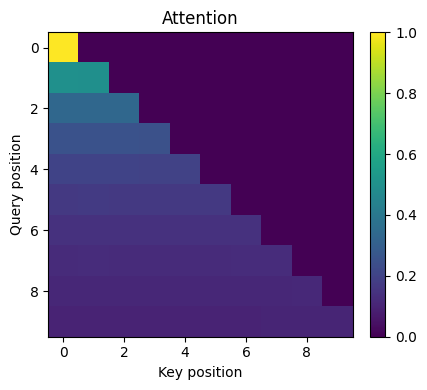

Saved as attention_head0.png


In [7]:
SEED = 360420
model = GPT(vocab_size=64, d_model=64, n_heads=8, n_layers=2, max_seq_len=16, positional_encoding="sinusoidal", weight_tying=True, seed=SEED)
x = np.random.default_rng(SEED).integers(0, model.vocab_size, size = (1, 10), dtype = np.int32)
_, _, attn = model.forward(x, return_attn=True)
attn_map = attn[0, 0]
plt.figure(figsize=(5, 4))
im = plt.imshow(attn_map, interpolation="nearest")
plt.title("Attention")
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("attention_head0.png", dpi=200)
plt.show()
print("Saved as attention_head0.png")
